## Explain the footprint heterogeneity

In [3]:
from basepair.imports import *

from basepair.exp.paper.config import *

fdir = Path(f'{ddir}/figures/method-comparison/vplot')
fdir.mkdir(exist_ok=True)

Using TensorFlow backend.


In [4]:
from basepair.cli.schemas import DataSpec, TaskSpec 
from pybedtools import BedTool
from basepair.preproc import resize_interval

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
paper_config()

In [6]:
ATAC_PROC_DIR = Path('/oak/stanford/groups/akundaje/projects/bpnet/ATACseq_processed')
CROO_DIR = ATAC_PROC_DIR / 'croo'
OUTPUT_DIR = Path('/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/data/atac')
METHODS = ['BPNet', 'MEME/FIMO']
dfi_list_dir = '/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/chexmix-peakxus'
closest_motifs = read_pkl("/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/chexmix-peakxus/closest_motifs.pkl")
motifs = list(closest_motifs)

In [7]:
df_id = pd.read_csv(ATAC_PROC_DIR / 'id_to_sample.txt', sep='\t',
                    usecols=['id', 'status', 'name', 'str_label'])

sample_to_id = {row.str_label: row.id for i,row in df_id.iterrows()}


samples = list(sample_to_id)

In [8]:
fasta_file = '/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/data/mm10_no_alt_analysis_set_ENCODE.fasta'

In [9]:
main_motifs = ['Oct4-Sox2', 'Sox2', 'Nanog', 'Klf4']

In [10]:
### Load the data

In [11]:
# dfi_list
dfi_list = read_pkl(f'{dfi_list_dir}/dfi_list.incl-conservation,is_erv.pkl')

dfi = dfi_list['BPNet']['dfi']

In [12]:
dict(dfi.example_chrom.value_counts())

{'chr2': 18216,
 'chr11': 16638,
 'chr1': 16558,
 'chr5': 16079,
 'chr4': 15817,
 'chr8': 14459,
 'chr7': 14229,
 'chr6': 13567,
 'chr9': 13068,
 'chr10': 13002,
 'chr3': 12079,
 'chr13': 11884,
 'chr17': 10609,
 'chr12': 9348,
 'chr14': 9332,
 'chr15': 9084,
 'chr16': 8419,
 'chr18': 7527,
 'chr19': 6525}

In [13]:
# ChIP-nexus profiles, ranges
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
model_dir = models_dir / exp

isf = ImpScoreFile(model_dir / 'deeplift.imp_score.h5', default_imp_score='profile/wn')

profiles = isf.get_profiles()
ranges = isf.get_ranges()
seqs = isf.get_seq()

In [31]:
ranges['example_idx'] = ranges['idx']

### Get the ATAC profiles

In [14]:
# Centered at the ChIP-nexus data
ds = DataSpec(task_specs={sample: TaskSpec(pos_counts=f'{OUTPUT_DIR}/{sample}/coverage.sub150bp-fragments.pos.bw',
                                           neg_counts=f'{OUTPUT_DIR}/{sample}/coverage.sub150bp-fragments.neg.bw',
                                           task=sample)
                          for sample in samples},
              fasta_file=fasta_file)

In [15]:
ds.touch_all_files()

In [16]:
from basepair.extractors import Interval

In [17]:
ranges

chrom      start        end strand interval_from_task     idx
0        chr9    3001633    3002633      .               Oct4       0
1        chr3  122145077  122146077      .               Oct4       1
2       chr13   21199761   21200761      .               Oct4       2
...       ...        ...        ...    ...                ...     ...
147971   chr9   65390119   65391119      .               Klf4  147971
147972  chr13   12440944   12441944      .               Klf4  147972
147973  chr13  101784985  101785985      .               Klf4  147973

[147974 rows x 6 columns]

In [18]:
from pybedtools import BedTool

In [19]:
all_intervals = list(BedTool.from_dataframe(ranges[['chrom', 'start', 'end']]))

In [20]:
tasks = ['Oct4', 'Sox2', 'Nanog', 'Klf4']

In [21]:
atac_profile = ds.load_counts(all_intervals)

### Analyze raw data

#### Fraction of ATAC peaks overlapping ChIP-nexus peaks

In [22]:
def atac_peak_path(sample):
    return f'{CROO_DIR}/{sample_to_id[sample]}/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz'

In [23]:
atac_peak_paths = {sample: atac_peak_path(sample) for sample in samples}

In [24]:
# Use new code from pyranges
import pyranges as pr

In [25]:
from pyranges import PyRanges
def read_bed(f, output_df=False, nrows=None):

    columns = "Chromosome Start End Name Score Strand ThickStart ThickEnd ItemRGB BlockCount BlockSizes BlockStarts".split(
    )

    if f.endswith(".gz"):
        import gzip
        first_start = gzip.open(f).readline().split()[1]
    else:
        first_start = open(f).readline().split()[1]

    header = None

    try:
        int(first_start)
    except ValueError:
        header = 0

    df = pd.read_csv(
        f,
        dtype={
            "Chromosome": "category",
            "Strand": "category"
        },
        nrows=nrows,
        header=header,
        sep="\t")

    df.columns = columns[:df.shape[1]]

    if not output_df:
        return PyRanges(df)
    else:
        return df

In [27]:
for sample in samples:
    atac_peaks = read_bed(atac_peak_path(sample))
    atac_peaks = atac_peaks[['Chromosome', 'Start', 'End', 'ThickStart', 'BlockCount']]
    # ThickStart -> signalValue
    # BlockCount -> peak
    atac_peaks = atac_peaks.set_columns(['Chromosome', 'Start', 'End', 'signal_value', 'peak_summit'])

    ranges_pr = pr.PyRanges(ranges.rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End', 'idx': 'example_idx'}))

    ranges[f'overlaps_{sample}'] = ranges['idx'].isin(ranges_pr.intersect(atac_peaks).example_idx.unique())

In [28]:
ranges[[c for c in ranges if c.startswith('overlaps_')]].mean()

overlaps_ATAC_SOX2ON_26h      0.2513
overlaps_ATAC_SOX2OFF_26h     0.1970
overlaps_ATAC_OCT4ON_S2iL     0.3693
overlaps_ATAC_OCT4OFF_S2iL    0.2349
overlaps_ATAC_SOX2ON_40h      0.3373
overlaps_ATAC_SOX2OFF_40h     0.2569
dtype: float64

### ATAC count distribution within ChIP-nexus peak

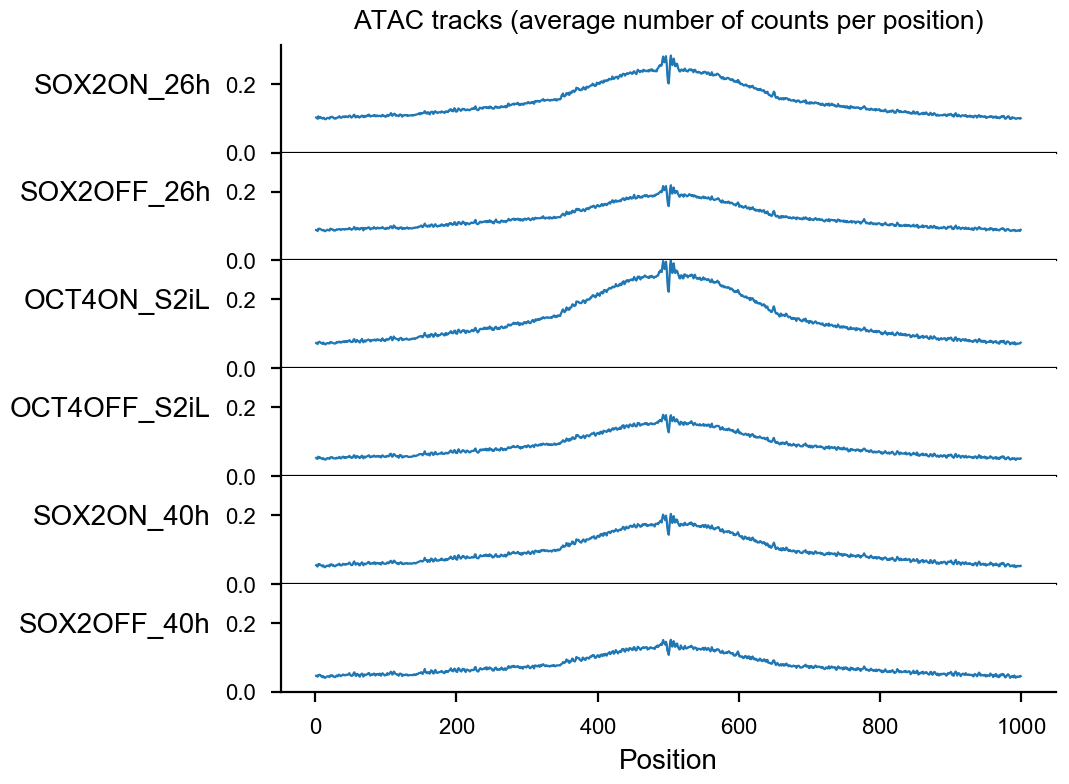

In [171]:
from basepair.plot.tracks import plot_tracks

plot_tracks({sample.replace('ATAC_', ''): counts.mean(axis=0).sum(axis=-1) for sample,counts in atac_profile.items()},
            fig_width=5,
            fig_height_per_track=.7,
            same_ylim=True,
            rotate_y=0,
            title=f'ATAC tracks (average number of counts per position)');
plt.xlabel('Position')
sns.despine(top=True, right=True)

#### ATAC counts at ChIP-nexus peaks that overlap/don't overlap ATAC peaks

In [29]:
# Append total number of counts to ranges
for sample,counts in atac_profile.items():
    ranges[sample] = counts.sum(axis=(1,2))

In [30]:
# tidy table
ranges_melt = ranges.melt(id_vars=[c for c in ranges.columns if c not in samples],
                          value_vars=samples)
ranges_melt['log10_value'] = np.log10(1+ranges_melt['value'])
ranges_melt['variable'] = ranges_melt['variable'].str.replace('ATAC_', '')
ranges_melt

chrom      start        end strand interval_from_task     idx  overlaps_ATAC_SOX2ON_26h  \
0        chr9    3001633    3002633      .               Oct4       0                     False   
1        chr3  122145077  122146077      .               Oct4       1                     False   
2       chr13   21199761   21200761      .               Oct4       2                      True   
...       ...        ...        ...    ...                ...     ...                       ...   
887841   chr9   65390119   65391119      .               Klf4  147971                     False   
887842  chr13   12440944   12441944      .               Klf4  147972                      True   
887843  chr13  101784985  101785985      .               Klf4  147973                     False   

        overlaps_ATAC_SOX2OFF_26h  overlaps_ATAC_OCT4ON_S2iL  overlaps_ATAC_OCT4OFF_S2iL  \
0                           True                      False                      False     
1                           True                       True                      False     
2                           True                       True                       True     
...                          ...                        ...                        ...     
887841                     False                      False                      False     
887842                     False                      False                      False     
887843                      True                       True                      False     

        overlaps_ATAC_SOX2ON_40h  overlaps_ATAC_SOX2OFF_40h     variable  value  log10_value  
0                          False                     False    SOX2ON_26h  198.0       2.2989  
1                           True                      True    SOX2ON_26h  142.0       2.1553  
2                           True                      True    SOX2ON_26h  212.0       2.3284  
...                          ...                       ...           ...    ...          ...  
887841                     False                     False   SOX2OFF_40h   56.0       1.7559  
887842                      True                     False   SOX2OFF_40h   23.0       1.3802  
887843                      True                      True   SOX2OFF_40h   99.0       2.0000  

[887844 rows x 15 columns]

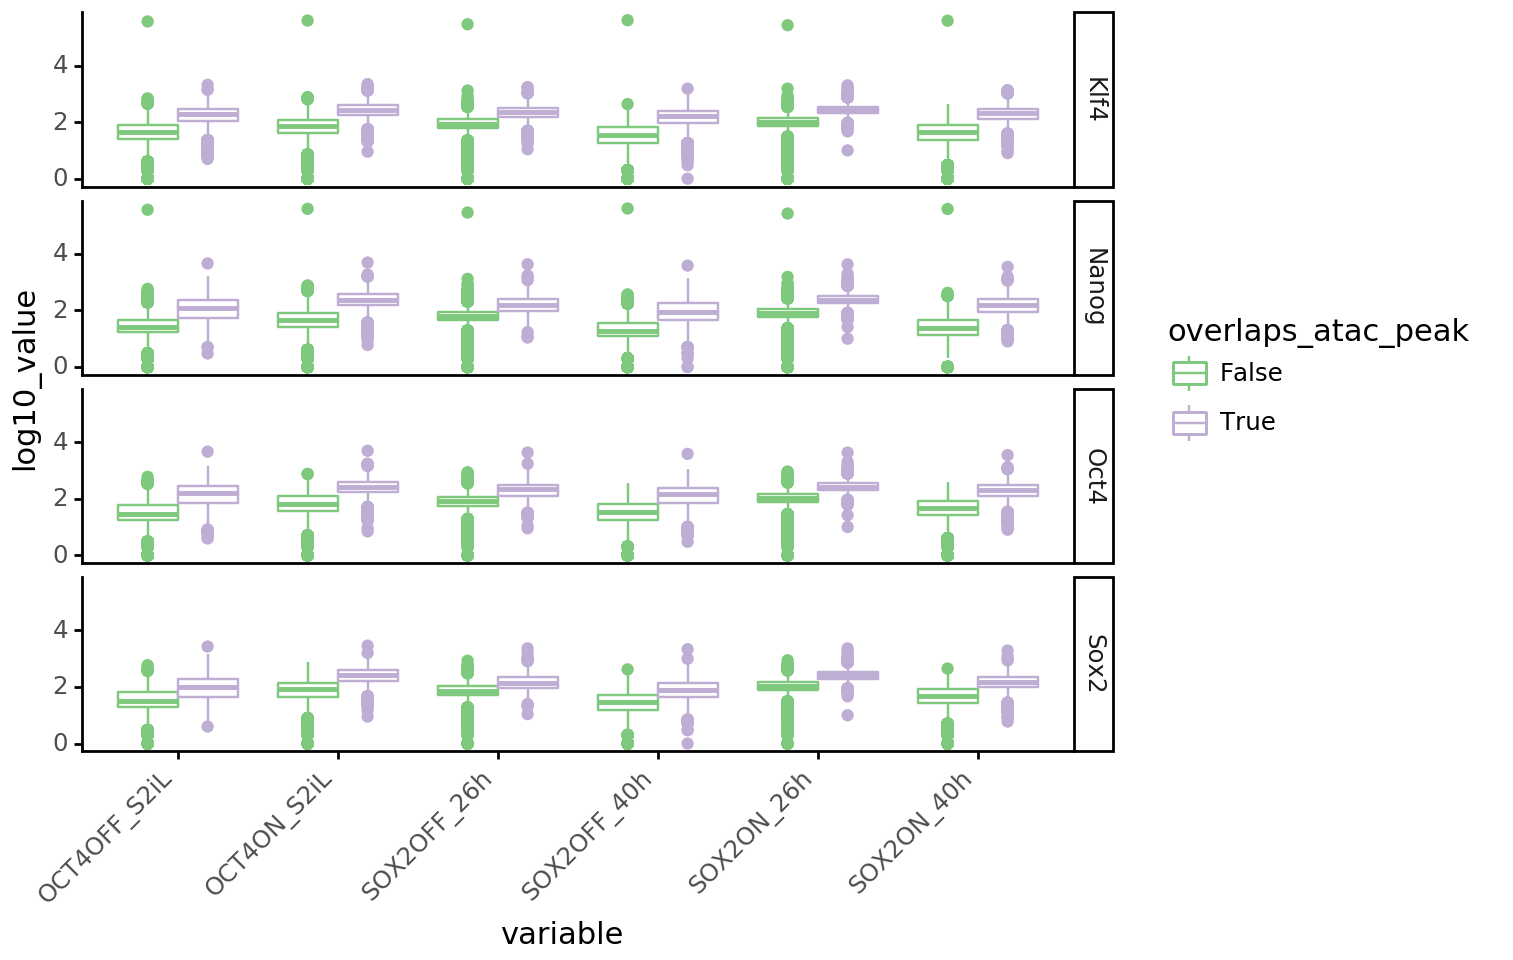

<ggplot: (8759959251632)>

In [175]:
from basepair.plot.utils import plt9_tilt_xlab

(ggplot(aes(x='variable', y='log10_value', color='overlaps_atac_peak'), data=ranges_melt)
 + facet_grid('interval_from_task ~ .')
 + geom_boxplot()
 + scale_color_brewer('qual')
 + theme_classic()
 + plt9_tilt_xlab()
)

### Model predictions

#### Create perturbed sequences

In [32]:
from basepair.exp.chipnexus.perturb.gen import random_seq_onehot
from kipoi.data import Dataset


class PerturbedMotifsSeq(Dataset):

    def __init__(self, dfi, seqs, index_col='example_idx'):
        self.dfi = dfi.copy().set_index(index_col, drop=False)
        self.seqs = seqs
        self.index_col = index_col

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        ref_seq = self.seqs[idx]
        # generate the alternative sequence
        alt_seq = ref_seq.copy()
        
        # Get instances
        if idx not in self.dfi.index:
            # no rows. Return the same sequence.
            return alt_seq
        instances = self.dfi.loc[[idx]]
        assert np.all(instances[self.index_col] == idx)
        
        # mutate alternative sequence
        for i,inst in instances.iterrows():
            seqlen = inst.pattern_end - inst.pattern_start
            alt_seq[int(inst.pattern_start):int(inst.pattern_end)] = random_seq_onehot(seqlen)

        return alt_seq

In [33]:
motifs

['Oct4-Sox2',
 'Oct4',
 'Oct4-Oct4',
 'B-Box',
 'Sox2',
 'Nanog',
 'Nanog-partner',
 'Zic3',
 'Klf4',
 'Klf4-Klf4',
 'Essrb']

In [221]:
dsox2_motifs = ['Oct4-Sox2', 'Sox2']
doct4_motifs = ['Oct4-Sox2', 'Oct4', 'Oct4-Oct4']

In [34]:
assert len(ranges) == len(seqs)

In [35]:
seq_dict = dict(wt=seqs,
                dsox2=PerturbedMotifsSeq(dfi[dfi.pattern_name.isin(dsox2_motifs)], seqs).load_all(num_workers=10),
                doct4=PerturbedMotifsSeq(dfi[dfi.pattern_name.isin(doct4_motifs)], seqs).load_all(num_workers=10))

100%|██████████| 4625/4625 [00:47<00:00, 98.25it/s] 


#### Create predictions

In [226]:
from basepair.BPNet import BPNetSeqModel

In [227]:
create_tf_session(2)

In [228]:
m = BPNetSeqModel.from_mdir(model_dir)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2020-01-04 13:23:01,167 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
Use the retry module or similar alternatives.


2020-01-04 13:23:18,555 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


In [ ]:
pred_dict = {k: m.predict(seq) for k,seq in seq_dict.items()}

### Create features

#### Number of motifs per region

In [70]:
X_feat = dfi.groupby(['example_idx', 'pattern_name']).size().unstack(fill_value=0).reset_index()
X_feat = pd.merge(ranges[['example_idx']], X_feat, on='example_idx', how='left').fillna(0)
del X_feat['example_idx']

In [73]:
def prefix_name(df, prefix):
    df = df.copy()
    df.columns = [prefix + c for c in df.columns]
    return df

In [78]:
ranges = pd.concat([ranges, prefix_name(X_feat, 'motif_counts_')], axis=1)

#### Motif interactions

### Compare ChIP-nexus counts to ATAC-seq signal

In [76]:
nexus_counts = pd.DataFrame({k:v.sum(axis=(1,2)) for k,v in profiles.items()})

In [79]:
ranges = pd.concat([ranges, nexus_counts], axis=1)

In [81]:
from basepair.plot.evaluate import regression_eval

In [83]:
tasks

['Oct4', 'Sox2', 'Nanog', 'Klf4']

In [90]:
from scipy.stats import pearsonr, spearmanr
df_cor_list = []
for sample in samples:
    for task in tasks:
        y_true = ranges[task]+1
        y_pred = ranges[sample]+1
        spearman, spearman_pval = spearmanr(np.log10(y_true), np.log(y_pred))
        df_cor_list.append(dict(sample=sample, task=task, spearman=spearman))
df_cor = pd.DataFrame(df_cor_list)

In [116]:
df_cor['tf_time'] = df_cor['sample'].map(lambda x: x[5:9] + '_' + x.split('_')[-1])
df_cor['TF_expressed'] = df_cor['sample'].map(lambda x: x.split('_')[1][4:])

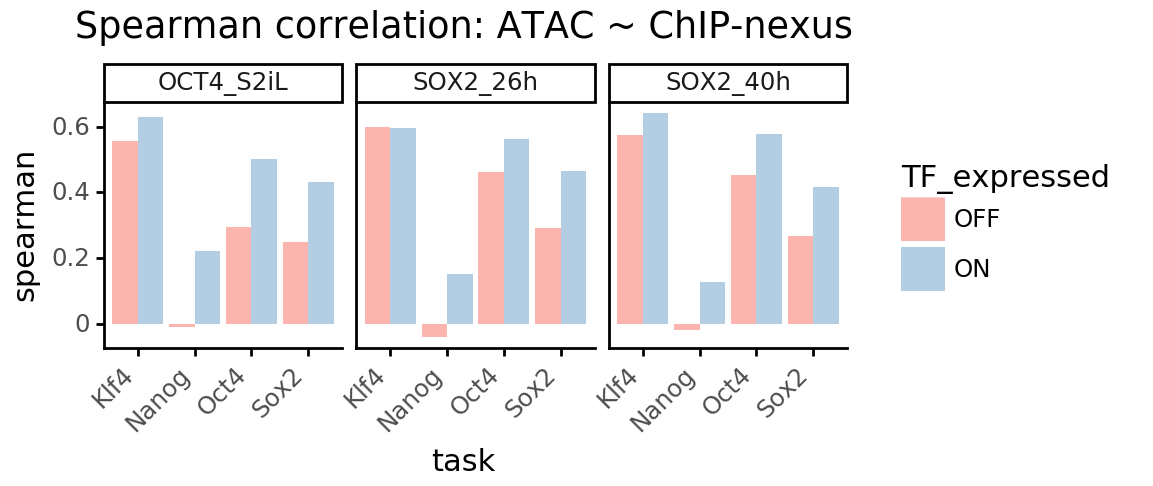

<ggplot: (-9223363283596150682)>

In [118]:
from basepair.plot.utils import plt9_tilt_xlab

plotnine.options.figure_size = get_figsize(.7, 1/3)
(ggplot(aes(x='task', y='spearman', fill='TF_expressed'), df_cor)
 + geom_bar(stat='identity', position='dodge')
 + facet_grid(".~tf_time")
 + scale_fill_brewer('qual', 4)
 + theme_classic()
 + plt9_tilt_xlab()
 + ggtitle("Spearman correlation: ATAC ~ ChIP-nexus")
)

#### Scatterplots: ATAC ~ ChIP-nexus

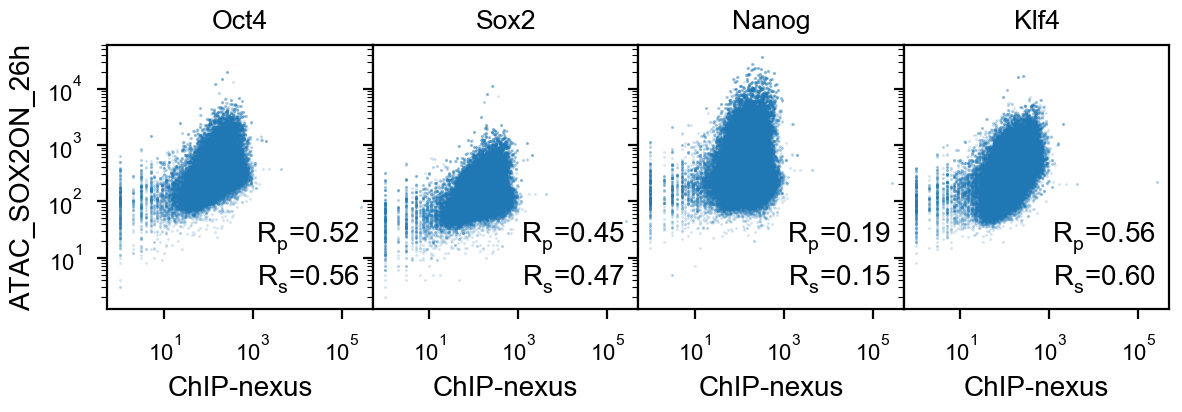

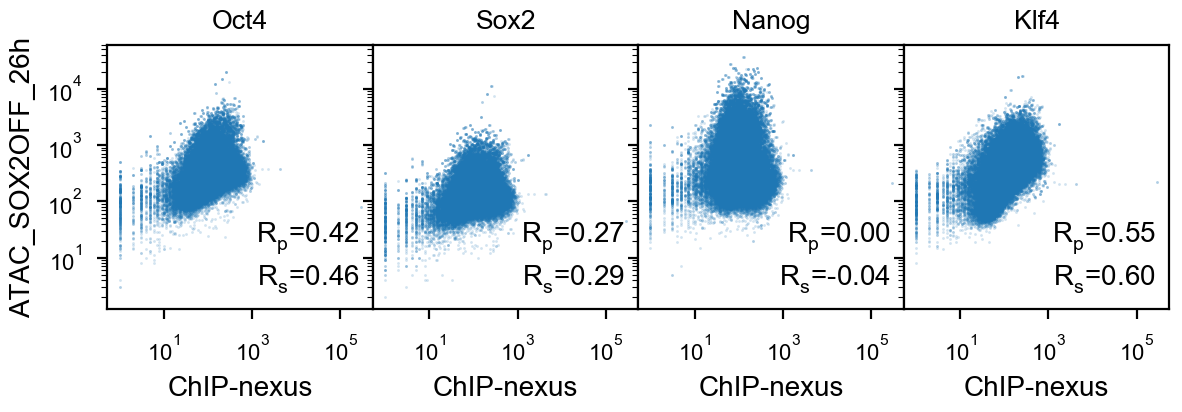

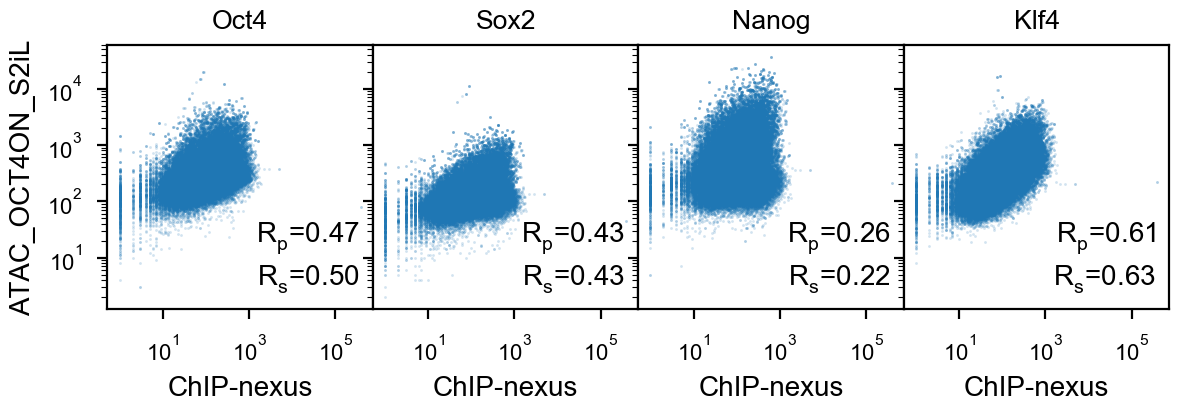

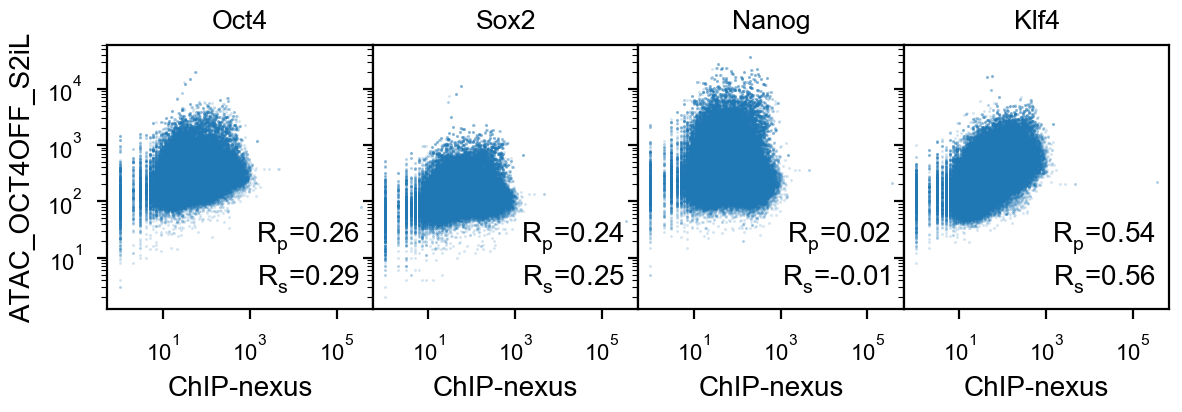

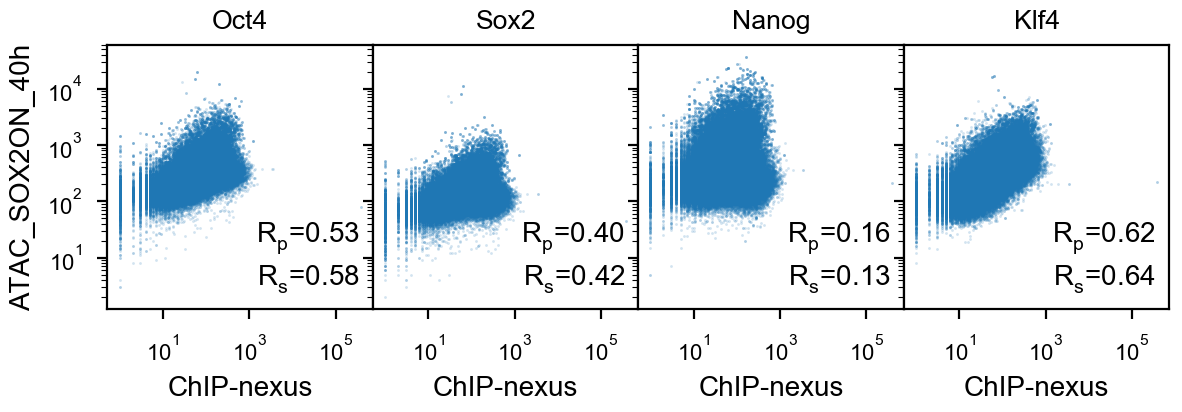

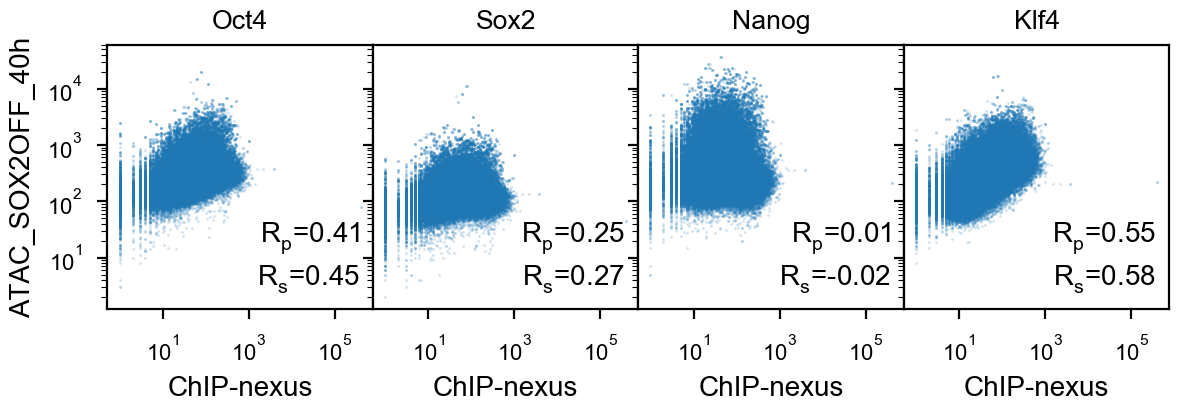

In [119]:
for sample in samples:
    fig, axes = plt.subplots(1, len(tasks),
                             figsize=get_figsize(1, aspect=1/len(tasks)),
                             gridspec_kw=dict(wspace=0),
                             sharex=True,
                             sharey=True)
    for i, (ax, task) in enumerate(zip(axes, tasks)):
        regression_eval(ranges[task]+1, ranges[sample]+1, loglog=True, task=task, alpha=0.2, ax=ax);
        if i == 0:
            ax.set_ylabel(sample)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel("ChIP-nexus")

In [80]:
ranges

chrom      start        end strand interval_from_task     idx  overlaps_ATAC_SOX2ON_26h  \
0        chr9    3001633    3002633      .               Oct4       0                     False   
1        chr3  122145077  122146077      .               Oct4       1                     False   
2       chr13   21199761   21200761      .               Oct4       2                      True   
...       ...        ...        ...    ...                ...     ...                       ...   
147971   chr9   65390119   65391119      .               Klf4  147971                     False   
147972  chr13   12440944   12441944      .               Klf4  147972                      True   
147973  chr13  101784985  101785985      .               Klf4  147973                     False   

        overlaps_ATAC_SOX2OFF_26h  overlaps_ATAC_OCT4ON_S2iL  overlaps_ATAC_OCT4OFF_S2iL  \
0                           True                      False                      False     
1                           True                       True                      False     
2                           True                       True                       True     
...                          ...                        ...                        ...     
147971                     False                      False                      False     
147972                     False                      False                      False     
147973                      True                       True                      False     

        overlaps_ATAC_SOX2ON_40h  overlaps_ATAC_SOX2OFF_40h  ATAC_SOX2ON_26h  ATAC_SOX2OFF_26h  \
0                          False                     False             198.0             204.0   
1                           True                      True             142.0             147.0   
2                           True                      True             212.0             284.0   
...                          ...                       ...               ...               ...   
147971                     False                     False              98.0              95.0   
147972                      True                     False             166.0              57.0   
147973                      True                      True             128.0             165.0   

        ATAC_OCT4ON_S2iL  ATAC_OCT4OFF_S2iL  ATAC_SOX2ON_40h  ATAC_SOX2OFF_40h  example_idx  \
0                   74.0               42.0             56.0              61.0            0   
1                  267.0               32.0            198.0             111.0            1   
2                  280.0              189.0            205.0             186.0            2   
...                  ...                ...              ...               ...          ...   
147971              57.0               65.0             54.0              56.0       147971   
147972              61.0               24.0             89.0              23.0       147972   
147973             131.0               29.0            100.0              99.0       147973   

        motif_counts_B-Box  motif_counts_Essrb  motif_counts_Klf4  motif_counts_Klf4-Klf4  \
0                      0.0                 0.0                0.0                     0.0   
1                      0.0                 0.0                0.0                     0.0   
2                      2.0                 0.0                0.0                     0.0   
...                    ...                 ...                ...                     ...   
147971                 0.0                 0.0                0.0                     0.0   
147972                 0.0                 0.0                0.0                     0.0   
147973                 0.0                 0.0                1.0                     0.0   

        motif_counts_Nanog  motif_counts_Nanog-partner  motif_counts_Oct4  motif_counts_Oct4-Oct4  \
0                      0.0                       0.0                  0.0             

### Define fold-change

In [120]:
ranges

chrom      start        end strand interval_from_task     idx  overlaps_ATAC_SOX2ON_26h  \
0        chr9    3001633    3002633      .               Oct4       0                     False   
1        chr3  122145077  122146077      .               Oct4       1                     False   
2       chr13   21199761   21200761      .               Oct4       2                      True   
...       ...        ...        ...    ...                ...     ...                       ...   
147971   chr9   65390119   65391119      .               Klf4  147971                     False   
147972  chr13   12440944   12441944      .               Klf4  147972                      True   
147973  chr13  101784985  101785985      .               Klf4  147973                     False   

        overlaps_ATAC_SOX2OFF_26h  overlaps_ATAC_OCT4ON_S2iL  overlaps_ATAC_OCT4OFF_S2iL  \
0                           True                      False                      False     
1                           True                       True                      False     
2                           True                       True                       True     
...                          ...                        ...                        ...     
147971                     False                      False                      False     
147972                     False                      False                      False     
147973                      True                       True                      False     

        overlaps_ATAC_SOX2ON_40h  overlaps_ATAC_SOX2OFF_40h  ATAC_SOX2ON_26h  ATAC_SOX2OFF_26h  \
0                          False                     False             198.0             204.0   
1                           True                      True             142.0             147.0   
2                           True                      True             212.0             284.0   
...                          ...                       ...               ...               ...   
147971                     False                     False              98.0              95.0   
147972                      True                     False             166.0              57.0   
147973                      True                      True             128.0             165.0   

        ATAC_OCT4ON_S2iL  ATAC_OCT4OFF_S2iL  ATAC_SOX2ON_40h  ATAC_SOX2OFF_40h  example_idx  \
0                   74.0               42.0             56.0              61.0            0   
1                  267.0               32.0            198.0             111.0            1   
2                  280.0              189.0            205.0             186.0            2   
...                  ...                ...              ...               ...          ...   
147971              57.0               65.0             54.0              56.0       147971   
147972              61.0               24.0             89.0              23.0       147972   
147973             131.0               29.0            100.0              99.0       147973   

        motif_counts_B-Box  motif_counts_Essrb  motif_counts_Klf4  motif_counts_Klf4-Klf4  \
0                      0.0                 0.0                0.0                     0.0   
1                      0.0                 0.0                0.0                     0.0   
2                      2.0                 0.0                0.0                     0.0   
...                    ...                 ...                ...                     ...   
147971                 0.0                 0.0                0.0                     0.0   
147972                 0.0                 0.0                0.0                     0.0   
147973                 0.0                 0.0                1.0                     0.0   

        motif_counts_Nanog  motif_counts_Nanog-partner  motif_counts_Oct4  motif_counts_Oct4-Oct4  \
0                      0.0                       0.0                  0.0             

In [125]:
_ranges_melt

variable  value  log10_counts
0        ATAC_SOX2ON_26h  198.0        2.2989
1        ATAC_SOX2ON_26h  142.0        2.1553
2        ATAC_SOX2ON_26h  212.0        2.3284
...                  ...    ...           ...
887841  ATAC_SOX2OFF_40h   56.0        1.7559
887842  ATAC_SOX2OFF_40h   23.0        1.3802
887843  ATAC_SOX2OFF_40h   99.0        2.0000

[887844 rows x 3 columns]

In [151]:
_ranges_melt['variable'] = pd.Categorical(_ranges_melt['variable'], samples, ordered=True)

In [160]:
_ranges_melt = ranges.melt(value_vars=samples)
_ranges_melt['log10_counts'] = np.log10(1 + _ranges_melt['value'])
_ranges_melt['variable'] = pd.Categorical(_ranges_melt['variable'], samples, ordered=True)
_ranges_melt['variable'].cat.rename_categories(lambda x: x.replace('ATAC_', ''), inplace=True)

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 24 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


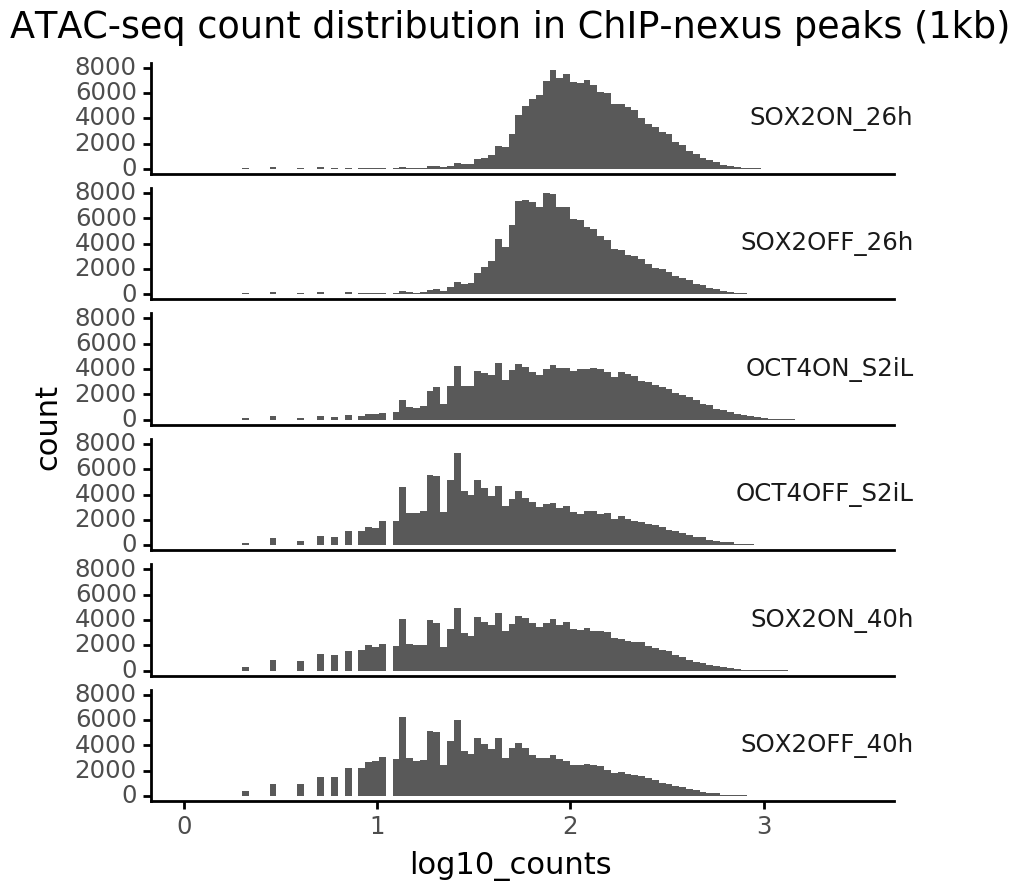

<ggplot: (-9223363283680757174)>

In [161]:
from basepair.plot.utils import plt9_horizontal_facet_label, plt9_remove_facet_label_box

plotnine.options.figure_size = get_figsize(.7, 1)
(ggplot(aes(x='log10_counts'), _ranges_melt)
 + geom_histogram(bins=100)
 + facet_grid('variable ~ .')
 + theme_classic()
 + plt9_horizontal_facet_label()
 + plt9_remove_facet_label_box()
 + xlim(0, 3.5)
 + ggtitle("ATAC-seq count distribution in ChIP-nexus peaks (1kb)")
)

In [173]:
on_samples = [s for s in samples if 'ON' in s]
feature_pairs = [(s, s.replace("ON", "OFF")) for s in samples if 'ON' in s]
sample_groups = [s.replace("ON", "").replace("ATAC_", "") for s in on_samples]

In [186]:
for on_sample in on_samples:
    counts_on = ranges[on_sample]
    counts_off = ranges[on_sample.replace("ON", "OFF")]
    counts_on_pc = np.percentile(counts_on, 10)
    counts_off_pc = np.percentile(counts_off, 10)
    fc = np.log10((counts_on + counts_on_pc) / (counts_off + counts_off_pc))
    ranges['log10_fc_' + on_sample.replace("ON", "").replace("ATAC_", "")] = fc

In [187]:
ranges[['log10_fc_' + s for s in sample_groups]].melt()

variable   value
0       log10_fc_SOX2_26h  0.0105
1       log10_fc_SOX2_26h  0.0159
2       log10_fc_SOX2_26h -0.0886
...                   ...     ...
443919  log10_fc_SOX2_40h  0.0000
443920  log10_fc_SOX2_40h  0.4949
443921  log10_fc_SOX2_40h  0.0119

[443922 rows x 2 columns]

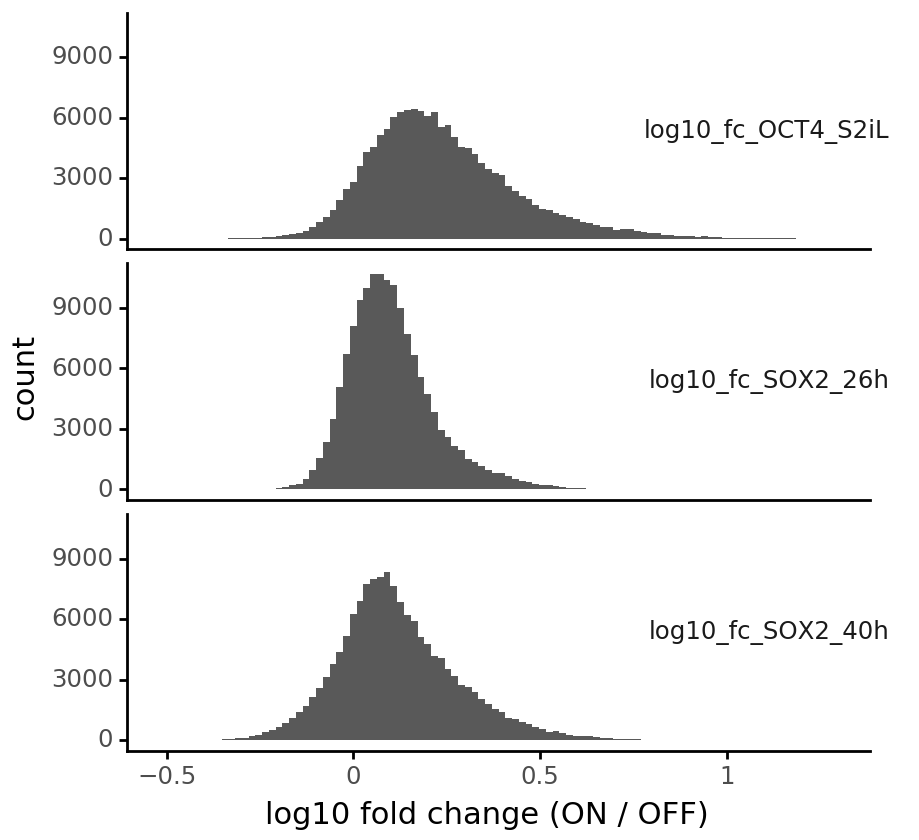

<ggplot: (-9223363283680991214)>

In [191]:
(ggplot(aes(x='value'), ranges[['log10_fc_' + s for s in sample_groups]].melt())
 + geom_histogram(bins=100)
 + theme_classic()
 + plt9_horizontal_facet_label()
 + plt9_remove_facet_label_box()
 + facet_grid("variable ~ .")
 + xlab("log10 fold change (ON / OFF)")
)

### Compare different models

fold_change ~ beta_TF1 * (alt_binding_TF1 - ref_binding_TF1) + ...

In [193]:
from scipy.stats import pearsonr, spearmanr
df_cor_list = []
for sample_group in sample_groups:
    for task in tasks:
        y_true = np.log10(ranges[task]+1)
        y_pred = ranges['log10_fc_' + sample_group]
        spearman, spearman_pval = spearmanr(y_true, y_pred)
        df_cor_list.append(dict(sample_group=sample_group, task=task, spearman=spearman))
df_cor = pd.DataFrame(df_cor_list)

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/guides/guides.py:198: UserWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
  "variable to it".format(output))


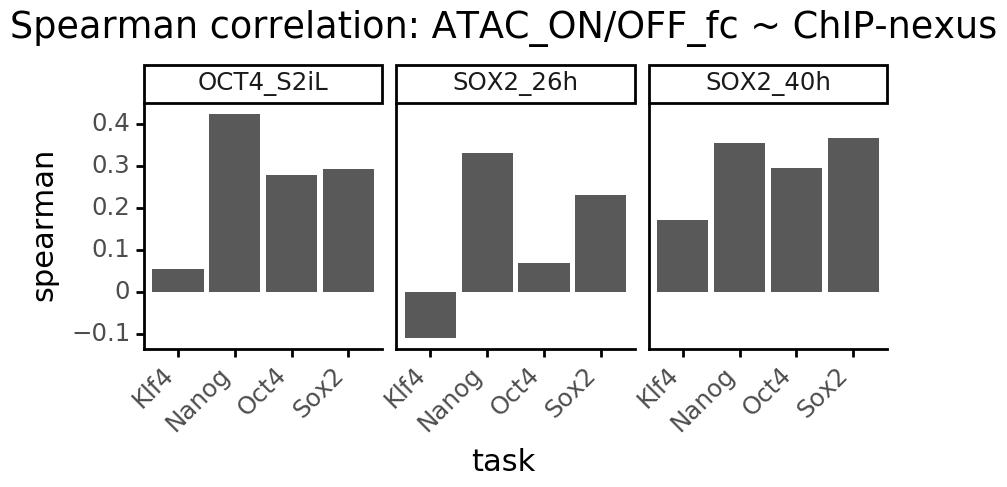

<ggplot: (-9223363283681098303)>

In [196]:
from basepair.plot.utils import plt9_tilt_xlab

plotnine.options.figure_size = get_figsize(.7, 1/3)
(ggplot(aes(x='task', y='spearman'), df_cor)
 + geom_bar(stat='identity', position='dodge')
 + facet_grid(".~sample_group")
 + scale_fill_brewer('qual', 4)
 + theme_classic()
 + plt9_tilt_xlab()
 + ggtitle("Spearman correlation: ATAC_ON/OFF_fc ~ ChIP-nexus")
)

### Create X

#### Summarize predictions

Counts in central 200 bp for each TF?

#### Motif counts (X_BPNet)

In [204]:
pred_dict.keys()

dict_keys(['wt', 'dsox2', 'doct4'])

In [205]:
pred_counts = {k: {task: v.sum(axis=(1,2)) for task,v in d.items()}
               for k,d in pred_dict.items()}

In [206]:
pred_max_profile = {k: {task: (v / v.sum(axis=1, keepdims=True)).max(axis=1).mean(axis=-1) for task,v in d.items()}
                    for k,d in pred_dict.items()}

In [234]:
X_bpnet_dsox2 = pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['dsox2'])
X_bpnet_doct4 = pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['doct4'])

#### Motif counts (X_motifs)

In [218]:
main_motifs

['Oct4-Sox2', 'Sox2', 'Nanog', 'Klf4']

In [225]:
motifs

['Oct4-Sox2',
 'Oct4',
 'Oct4-Oct4',
 'B-Box',
 'Sox2',
 'Nanog',
 'Nanog-partner',
 'Zic3',
 'Klf4',
 'Klf4-Klf4',
 'Essrb']

In [219]:
dsox2_motifs

['Oct4-Sox2', 'Sox2']

In [220]:
doct4_motifs

['Oct4-Sox2', 'Oct4', 'Oct4-Oct4']

In [230]:
X_motif_counts = ranges[['motif_counts_' + motif for motif in motifs]]
X_motif_counts.columns = [c.replace('motif_counts_', '') for c in X_motif_counts.columns]

In [231]:
X_motif_counts

Oct4-Sox2  Oct4  Oct4-Oct4  B-Box  Sox2  Nanog  Nanog-partner  Zic3  Klf4  Klf4-Klf4  \
0             0.0   0.0        0.0    0.0   0.0    0.0            0.0   0.0   0.0        0.0   
1             4.0   0.0        0.0    0.0   0.0    4.0            0.0   0.0   0.0        0.0   
2             0.0   0.0        0.0    2.0   0.0    0.0            0.0   0.0   0.0        0.0   
...           ...   ...        ...    ...   ...    ...            ...   ...   ...        ...   
147971        0.0   0.0        0.0    0.0   0.0    0.0            0.0   0.0   0.0        0.0   
147972        0.0   0.0        0.0    0.0   0.0    0.0            0.0   0.0   0.0        0.0   
147973        0.0   0.0        0.0    0.0   1.0    0.0            0.0   0.0   1.0        0.0   

        Essrb  
0         0.0  
1         0.0  
2         0.0  
...       ...  
147971    0.0  
147972    0.0  
147973    0.0  

[147974 rows x 11 columns]

In [232]:
X_motif_counts_dsox2 = X_motif_counts[dsox2_motifs]  # wt - ref -> all the motifs cancel out except the key {dsox2_motifs}
X_motif_counts_doct4 = X_motif_counts[doct4_motifs]

In [224]:
ranges

chrom      start        end strand interval_from_task     idx  overlaps_ATAC_SOX2ON_26h  \
0        chr9    3001633    3002633      .               Oct4       0                     False   
1        chr3  122145077  122146077      .               Oct4       1                     False   
2       chr13   21199761   21200761      .               Oct4       2                      True   
...       ...        ...        ...    ...                ...     ...                       ...   
147971   chr9   65390119   65391119      .               Klf4  147971                     False   
147972  chr13   12440944   12441944      .               Klf4  147972                      True   
147973  chr13  101784985  101785985      .               Klf4  147973                     False   

        overlaps_ATAC_SOX2OFF_26h  overlaps_ATAC_OCT4ON_S2iL  overlaps_ATAC_OCT4OFF_S2iL  \
0                           True                      False                      False     
1                           True                       True                      False     
2                           True                       True                       True     
...                          ...                        ...                        ...     
147971                     False                      False                      False     
147972                     False                      False                      False     
147973                      True                       True                      False     

        overlaps_ATAC_SOX2ON_40h  overlaps_ATAC_SOX2OFF_40h  ATAC_SOX2ON_26h  ATAC_SOX2OFF_26h  \
0                          False                     False             198.0             204.0   
1                           True                      True             142.0             147.0   
2                           True                      True             212.0             284.0   
...                          ...                       ...               ...               ...   
147971                     False                     False              98.0              95.0   
147972                      True                     False             166.0              57.0   
147973                      True                      True             128.0             165.0   

        ATAC_OCT4ON_S2iL  ATAC_OCT4OFF_S2iL  ATAC_SOX2ON_40h  ATAC_SOX2OFF_40h  example_idx  \
0                   74.0               42.0             56.0              61.0            0   
1                  267.0               32.0            198.0             111.0            1   
2                  280.0              189.0            205.0             186.0            2   
...                  ...                ...              ...               ...          ...   
147971              57.0               65.0             54.0              56.0       147971   
147972              61.0               24.0             89.0              23.0       147972   
147973             131.0               29.0            100.0              99.0       147973   

        motif_counts_B-Box  motif_counts_Essrb  motif_counts_Klf4  motif_counts_Klf4-Klf4  \
0                      0.0                 0.0                0.0                     0.0   
1                      0.0                 0.0                0.0                     0.0   
2                      2.0                 0.0                0.0                     0.0   
...                    ...                 ...                ...                     ...   
147971                 0.0                 0.0                0.0                     0.0   
147972                 0.0                 0.0                0.0                     0.0   
147973                 0.0                 0.0                1.0                     0.0   

        motif_counts_Nanog  motif_counts_Nanog-partner  motif_counts_Oct4  motif_counts_Oct4-Oct4  \
0                      0.0                       0.0                  0.0             

#### Fold change (Y)

In [236]:
Y = ranges[['log10_fc_' + g for g in sample_groups]]
Y

log10_fc_SOX2_26h  log10_fc_OCT4_S2iL  log10_fc_SOX2_40h
0                  0.0105              0.2374            -0.0190
1                  0.0159              0.8062             0.2410
2                 -0.0886              0.1732             0.0444
...                   ...                 ...                ...
147971             0.0454              0.0000             0.0000
147972             0.3492              0.3456             0.4949
147973            -0.0562              0.5586             0.0119

[147974 rows x 3 columns]

In [14]:
# Fit linear model

In [247]:
from basepair.datasets import *
from basepair.config import valid_chr, test_chr
from kipoi.data_utils import numpy_collate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from basepair.plot.evaluate import regression_eval

In [252]:
train = ~ranges.chrom.isin(valid_chr+test_chr)
valid = ranges.chrom.isin(valid_chr)
test = ranges.chrom.isin(test_chr)

In [269]:
datasets = {"dSox2": {"y": Y['log10_fc_SOX2_26h'],
                      "x_list": {
                          'BPNet_diff': pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['dsox2']),
                          'BPNet_log_fc': np.log(pd.DataFrame(pred_counts['wt']) / pd.DataFrame(pred_counts['dsox2'])),
                          'BPNet_maxref_fc': np.log(pd.DataFrame(pred_max_profile['wt']) / pd.DataFrame(pred_max_profile['dsox2'])),
                          'BPNet_maxref_diff': pd.DataFrame(pred_max_profile['wt']) - pd.DataFrame(pred_max_profile['dsox2']),
                          'BPNet_log_diff': np.log(pd.DataFrame(pred_counts['wt'])) - np.log(pd.DataFrame(pred_counts['dsox2'])),
                          'motif_counts': X_motif_counts[dsox2_motifs],
                          'BPNet_wt_log': np.log(pd.DataFrame(pred_counts['wt'])),
                          'wt_motif_counts': X_motif_counts,
                      }},
            "dSox2_40h": {"y": Y['log10_fc_SOX2_40h'],
                          "x_list": {
                             'BPNet_diff': pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['dsox2']),
                             'BPNet_log_fc': np.log(pd.DataFrame(pred_counts['wt']) / pd.DataFrame(pred_counts['dsox2'])),
                             'BPNet_maxref_fc': np.log(pd.DataFrame(pred_max_profile['wt']) / pd.DataFrame(pred_max_profile['dsox2'])),
                             'BPNet_maxref_diff': pd.DataFrame(pred_max_profile['wt']) - pd.DataFrame(pred_max_profile['dsox2']),
                             'BPNet_log_diff': np.log(pd.DataFrame(pred_counts['wt'])) - np.log(pd.DataFrame(pred_counts['dsox2'])),
                             'motif_counts': X_motif_counts[dsox2_motifs],
                             'BPNet_wt_log': np.log(pd.DataFrame(pred_counts['wt'])),
                             'wt_motif_counts': X_motif_counts,
                      }},
            "dOct4": {"y": Y['log10_fc_OCT4_S2iL'],
                      "x_list": {
                          'BPNet_diff': pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['doct4']),
                          'BPNet_log_fc': np.log(pd.DataFrame(pred_counts['wt']) / pd.DataFrame(pred_counts['doct4'])),
                          'BPNet_log_diff': np.log(pd.DataFrame(pred_counts['wt'])) - np.log(pd.DataFrame(pred_counts['doct4'])),
                          'BPNet_maxref_diff': pd.DataFrame(pred_max_profile['wt']) - pd.DataFrame(pred_max_profile['doct4']),
                          'BPNet_maxref_fc': np.log(pd.DataFrame(pred_max_profile['wt']) / pd.DataFrame(pred_max_profile['doct4'])),
                          'motif_counts': X_motif_counts[doct4_motifs],
                          'BPNet_wt_log': np.log(pd.DataFrame(pred_counts['wt'])),
                          'wt_motif_counts': X_motif_counts,
                      }},
           }

dSox2
dSox2_40h
dOct4


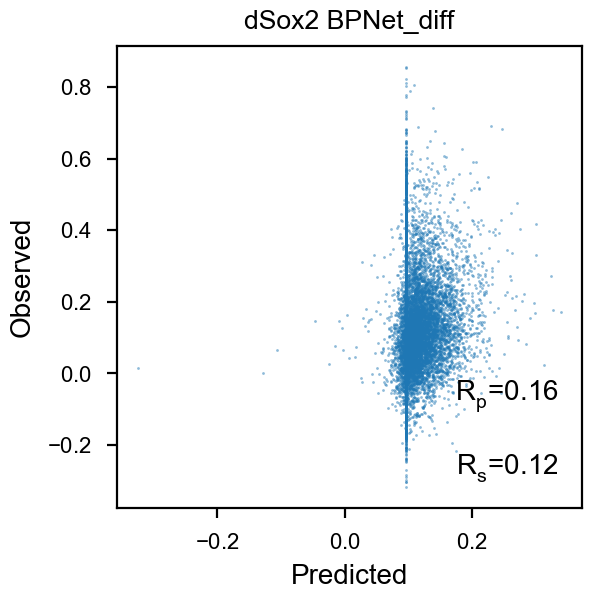

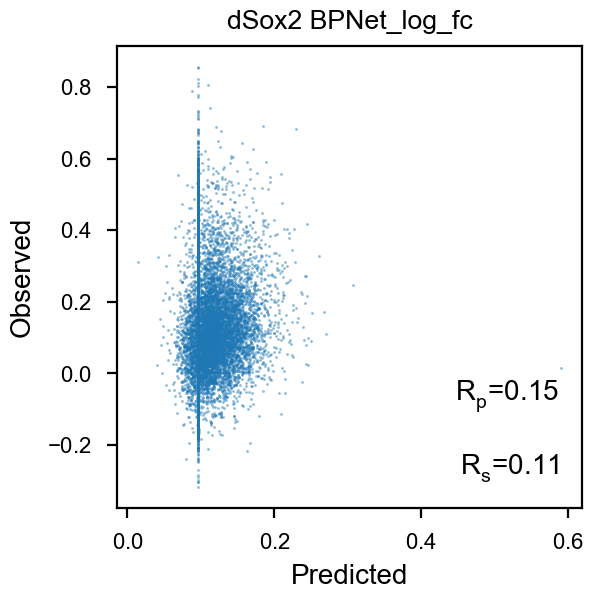

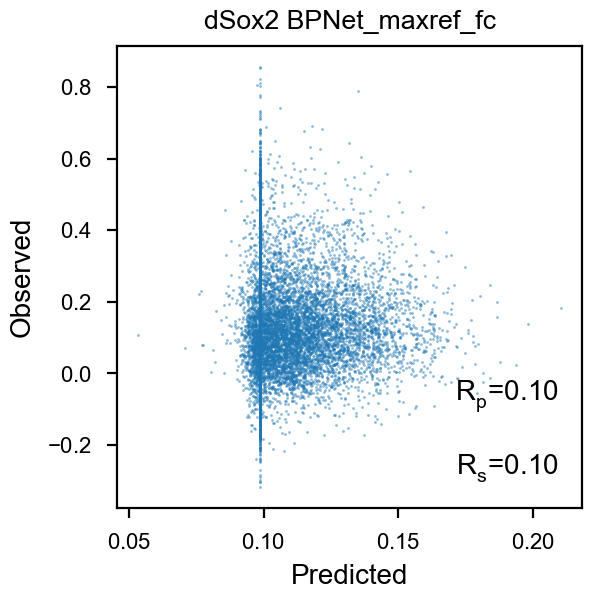

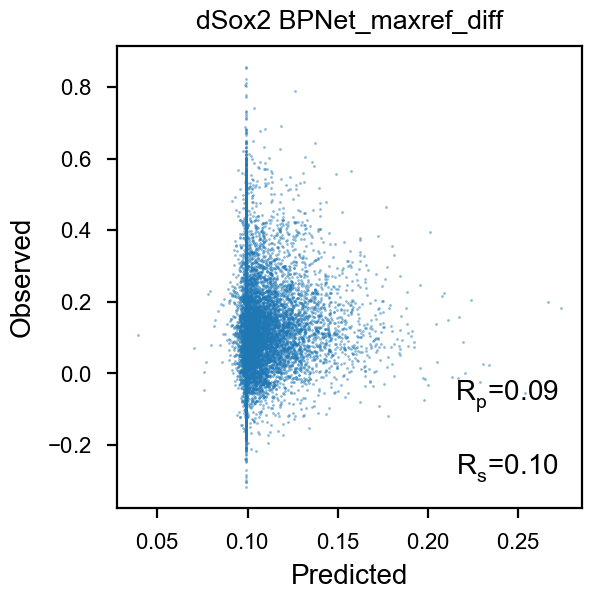

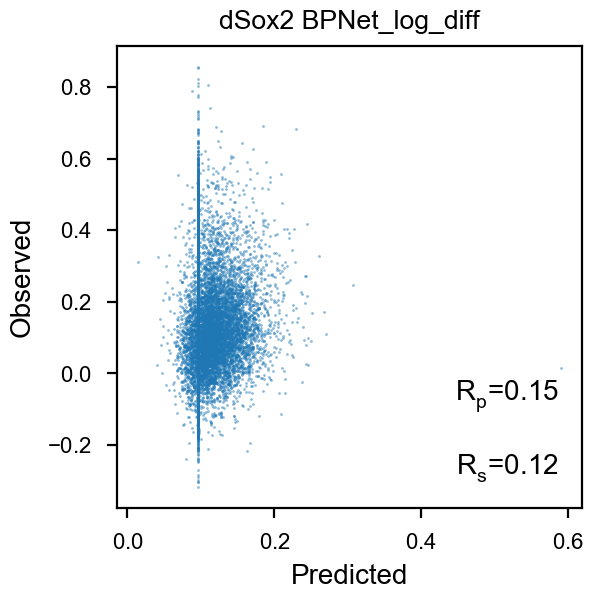

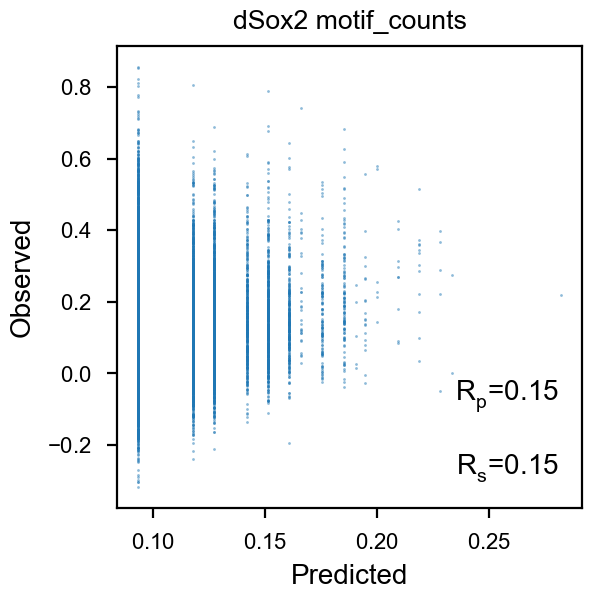

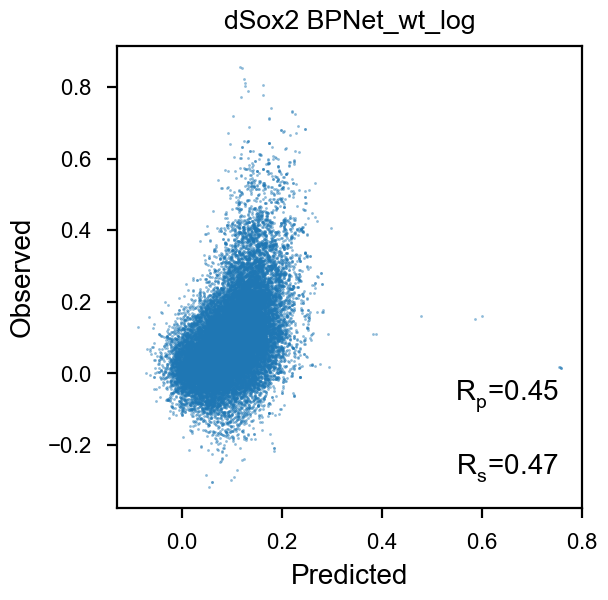

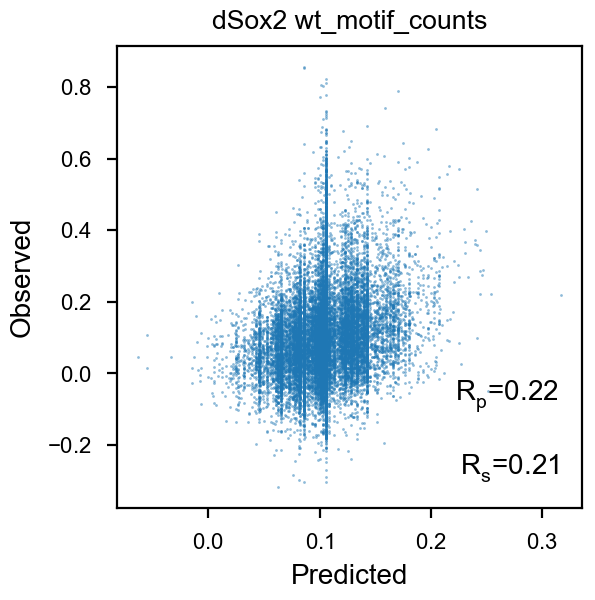

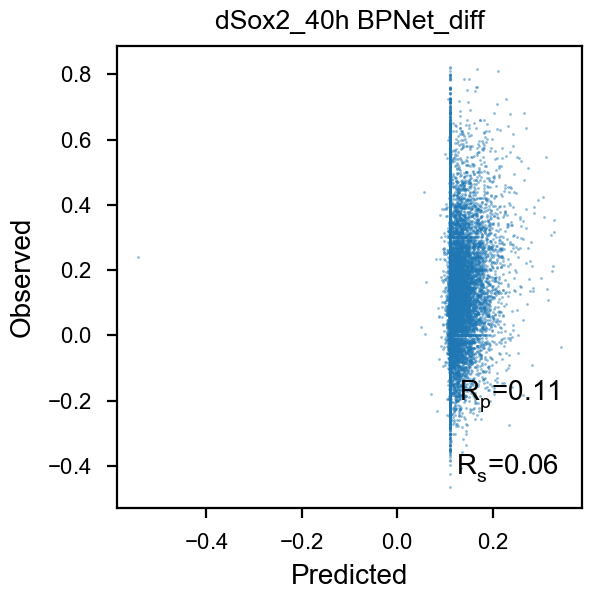

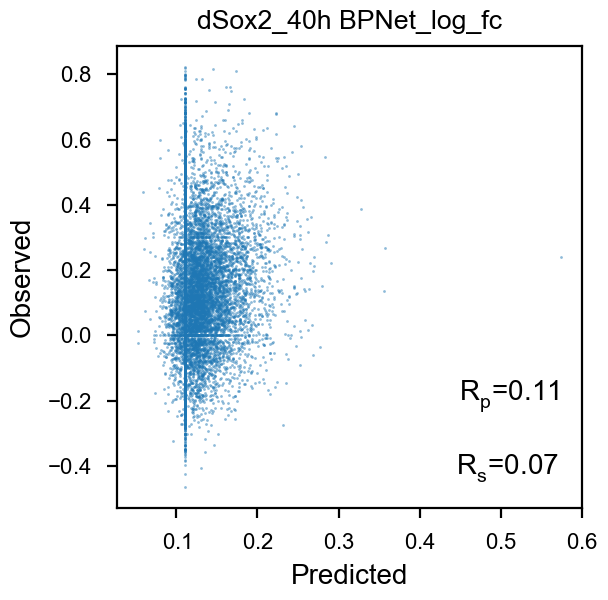

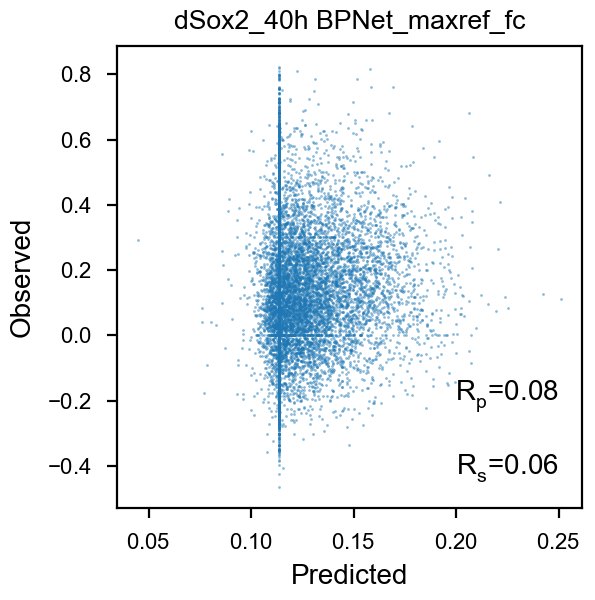

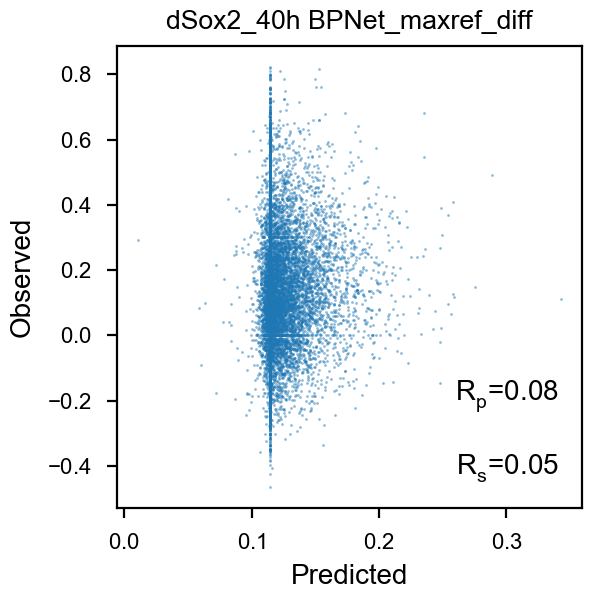

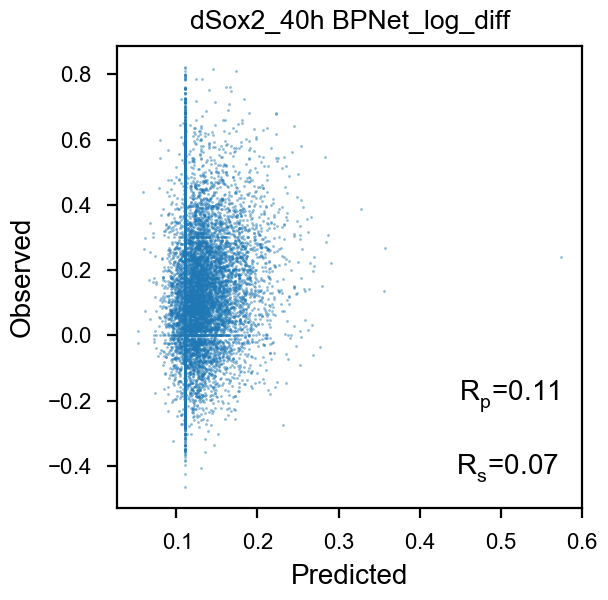

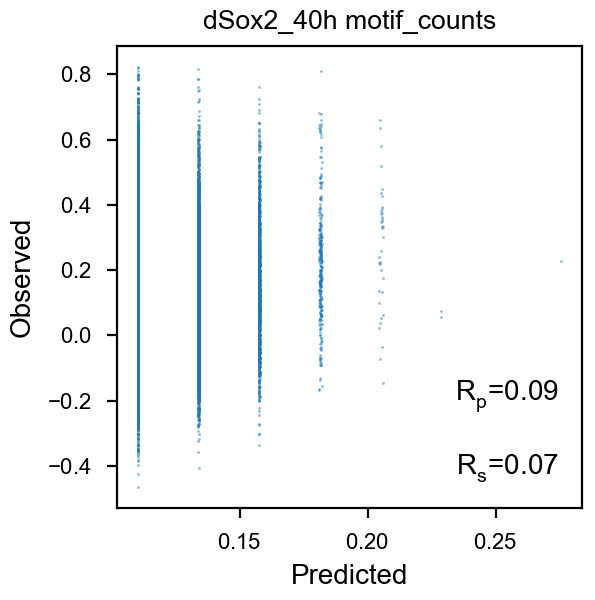

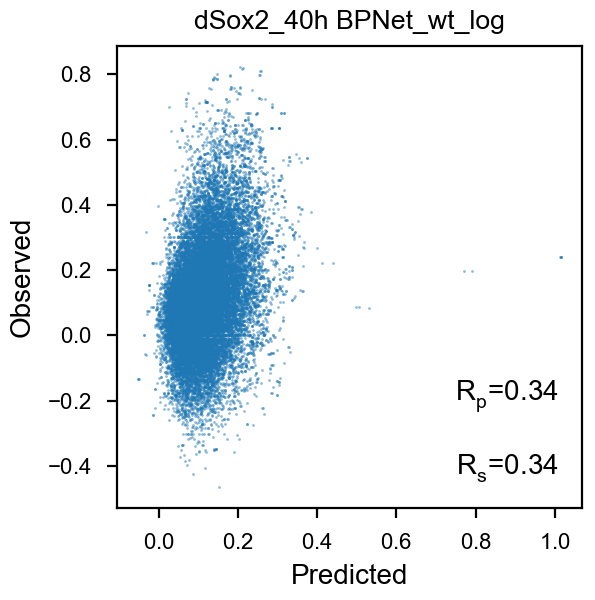

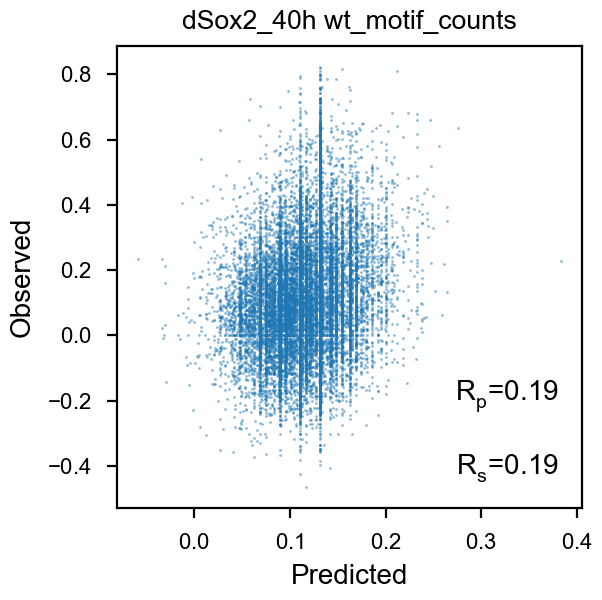

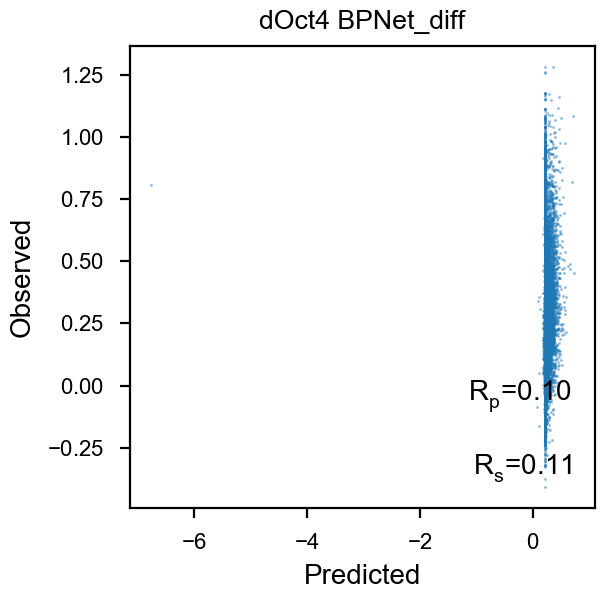

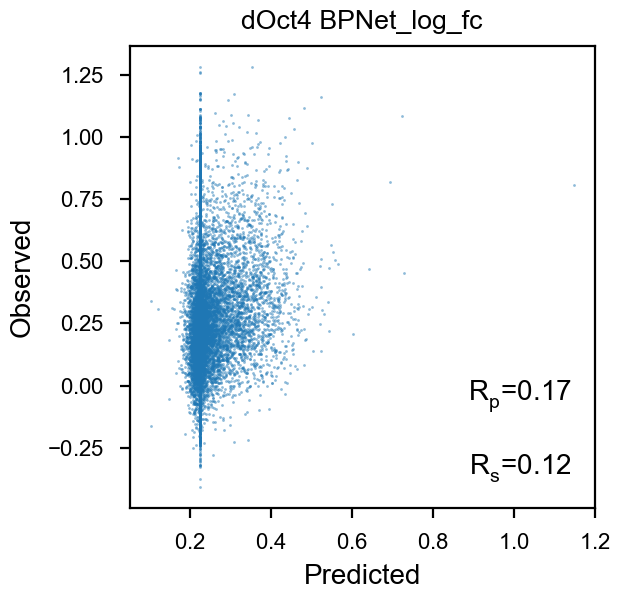

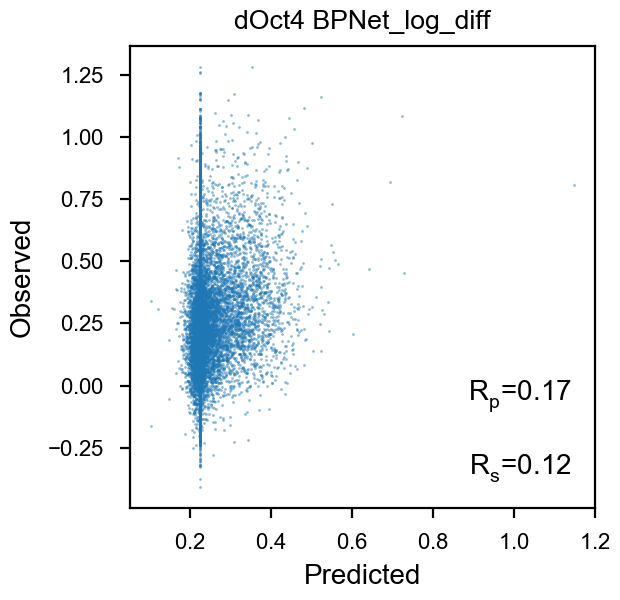

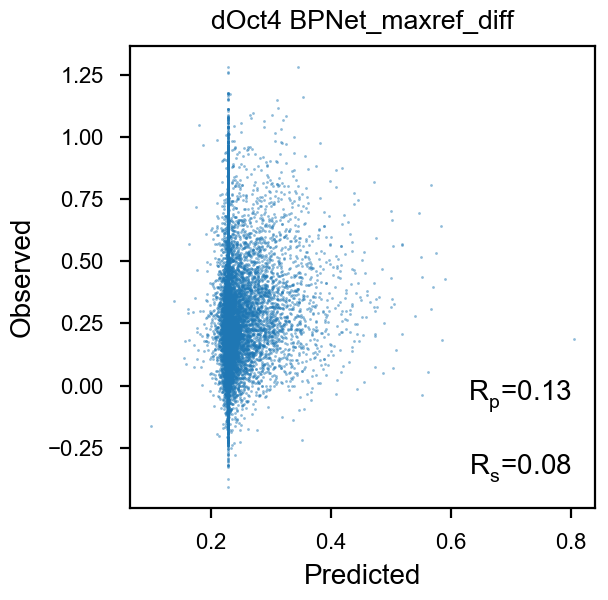

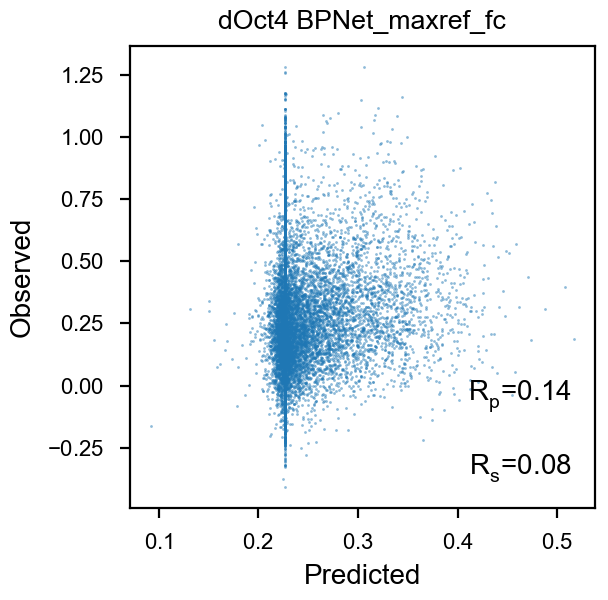

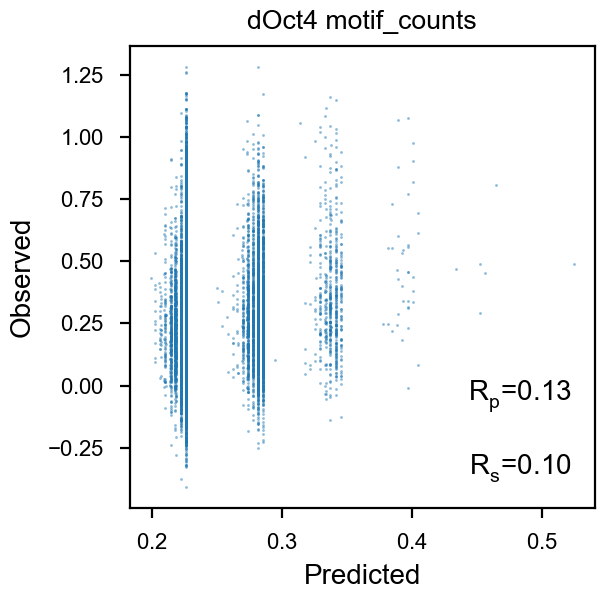

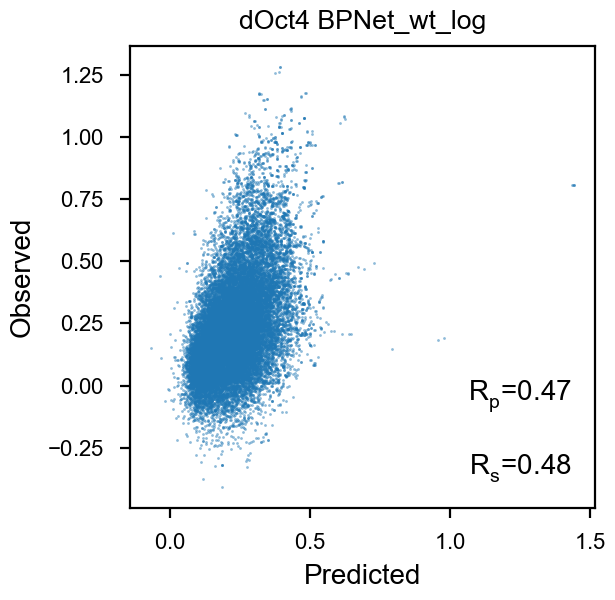

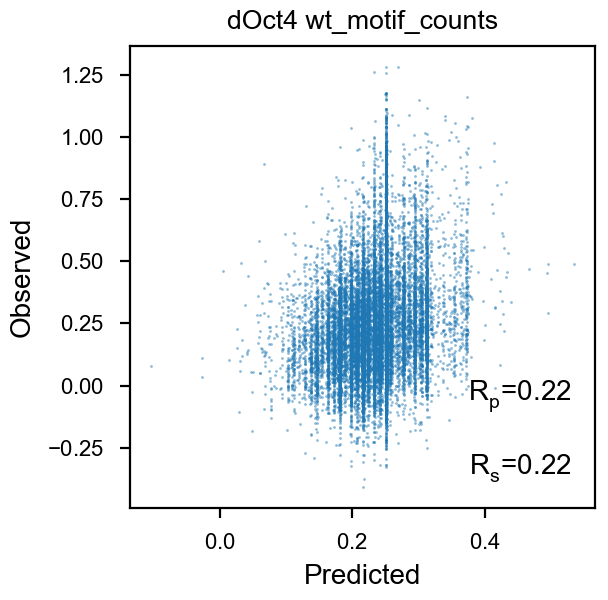

In [270]:
for dataset,v in datasets.items():
    print(dataset)
    y = v['y']
    for method, X in v['x_list'].items():
        m = LinearRegression()
        m.fit(X[train].values, y[train].values)
        preds = m.predict(X[valid])
        fig, ax = plt.subplots(figsize=(3, 3))
        regression_eval(y[valid], preds, task=f'{dataset} {method}', alpha=0.5, ax=ax);

In [ ]:
yscaler = StandardScaler()
y = yscaler.fit_transform(np.log10(y + 1).values, y=None)

In [ ]:
i = 0
for i in range(Y.shape[1]):
    fig, ax = plt.subplots(figsize=(3, 3))
    print(i, Y.columns[i])
    m = LinearRegression()
    m.fit(x.values, y[:,i])
    preds = m.predict(x_valid)
    regression_eval(y_valid[:,i], preds, task=y_cols[i], alpha=0.5, ax=ax);

In [15]:
# Compare predictions (test-set)